**MixUp: Interpolating Data for Robust Representations.**

Training with Raw Images
Epoch 1: Train Loss: 1.1859, Test Loss: 1.0217, Accuracy: 64.31%
Epoch 2: Train Loss: 0.8304, Test Loss: 0.8186, Accuracy: 71.72%
Epoch 3: Train Loss: 0.7047, Test Loss: 0.7795, Accuracy: 73.66%
Epoch 4: Train Loss: 0.6122, Test Loss: 0.7610, Accuracy: 74.09%
Epoch 5: Train Loss: 0.5420, Test Loss: 0.7857, Accuracy: 73.33%
Epoch 6: Train Loss: 0.4813, Test Loss: 0.7741, Accuracy: 74.30%
Epoch 7: Train Loss: 0.4207, Test Loss: 0.7437, Accuracy: 75.40%
Epoch 8: Train Loss: 0.3758, Test Loss: 0.7209, Accuracy: 76.35%
Epoch 9: Train Loss: 0.3297, Test Loss: 0.7378, Accuracy: 76.98%
Epoch 10: Train Loss: 0.2837, Test Loss: 0.7556, Accuracy: 76.37%
Epoch 11: Train Loss: 0.2498, Test Loss: 0.8080, Accuracy: 76.72%
Epoch 12: Train Loss: 0.2089, Test Loss: 0.8619, Accuracy: 75.77%
Epoch 13: Train Loss: 0.1859, Test Loss: 0.8334, Accuracy: 76.28%
Epoch 14: Train Loss: 0.1660, Test Loss: 0.8395, Accuracy: 76.47%
Epoch 15: Train Loss: 0.1374, Test Loss: 0.8773, Accuracy: 7

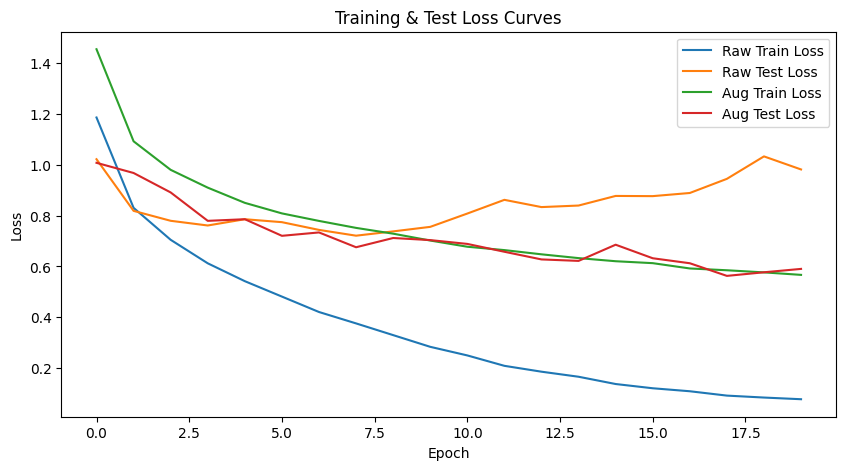

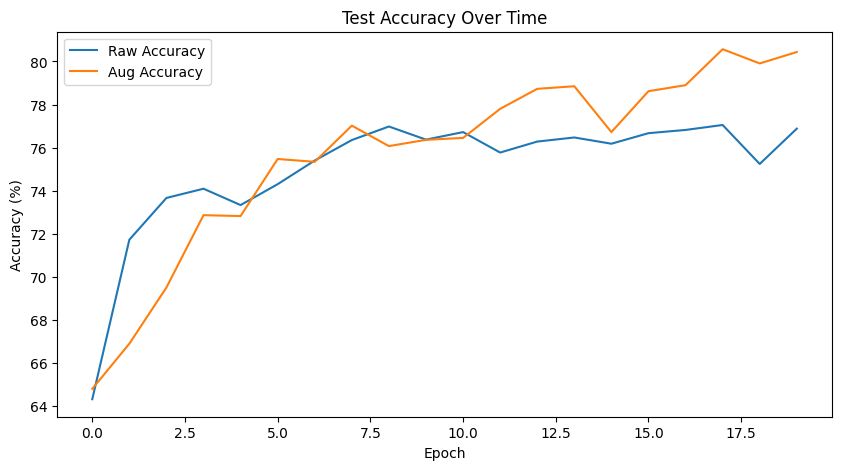

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_cnn_model():
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 10)
    )
    return model.to(device)

def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs):
    train_losses, test_losses, accuracies = [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_losses.append(running_loss / len(train_loader.dataset))

        model.eval()
        test_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracies.append(accuracy.item())

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")
    return train_losses, test_losses, accuracies

if __name__ == "__main__":
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001

    transform_raw = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_raw)
    trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_aug)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_raw)

    train_loader_raw = torch.utils.data.DataLoader(trainset_raw, batch_size=batch_size, shuffle=True)
    train_loader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()

    print("Training with Raw Images")
    model_raw = get_cnn_model()
    optimizer_raw = optim.Adam(model_raw.parameters(), lr=learning_rate)
    train_losses_raw, test_losses_raw, accuracies_raw = train_model(model_raw, train_loader_raw, test_loader, optimizer_raw, criterion, num_epochs)

    print("\nTraining with Traditional Augmentations")
    model_aug = get_cnn_model()
    optimizer_aug = optim.Adam(model_aug.parameters(), lr=learning_rate)
    train_losses_aug, test_losses_aug, accuracies_aug = train_model(model_aug, train_loader_aug, test_loader, optimizer_aug, criterion, num_epochs)


    plt.figure(figsize=(10,5))
    plt.plot(train_losses_raw, label='Raw Train Loss')
    plt.plot(test_losses_raw, label='Raw Test Loss')
    plt.plot(train_losses_aug, label='Aug Train Loss')
    plt.plot(test_losses_aug, label='Aug Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Test Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(accuracies_raw, label='Raw Accuracy')
    plt.plot(accuracies_aug, label='Aug Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Over Time")
    plt.legend()
    plt.show()



Training with Mixup Augmentation
[Mixup] Epoch 1/20 | Train Loss: 1.8246 | Test Loss: 1.2442 | Accuracy: 56.80%
[Mixup] Epoch 2/20 | Train Loss: 1.5976 | Test Loss: 1.1009 | Accuracy: 62.10%
[Mixup] Epoch 3/20 | Train Loss: 1.5008 | Test Loss: 1.0374 | Accuracy: 65.35%
[Mixup] Epoch 4/20 | Train Loss: 1.5000 | Test Loss: 1.2796 | Accuracy: 56.33%
[Mixup] Epoch 5/20 | Train Loss: 1.4461 | Test Loss: 1.0299 | Accuracy: 65.85%
[Mixup] Epoch 6/20 | Train Loss: 1.4164 | Test Loss: 0.9692 | Accuracy: 68.54%
[Mixup] Epoch 7/20 | Train Loss: 1.3673 | Test Loss: 0.9420 | Accuracy: 69.57%
[Mixup] Epoch 8/20 | Train Loss: 1.3656 | Test Loss: 0.9796 | Accuracy: 67.73%
[Mixup] Epoch 9/20 | Train Loss: 1.3286 | Test Loss: 0.9288 | Accuracy: 69.41%
[Mixup] Epoch 10/20 | Train Loss: 1.2937 | Test Loss: 0.9455 | Accuracy: 68.52%
[Mixup] Epoch 11/20 | Train Loss: 1.2889 | Test Loss: 0.9315 | Accuracy: 69.40%
[Mixup] Epoch 12/20 | Train Loss: 1.2544 | Test Loss: 0.8823 | Accuracy: 71.41%
[Mixup] Epoch 1

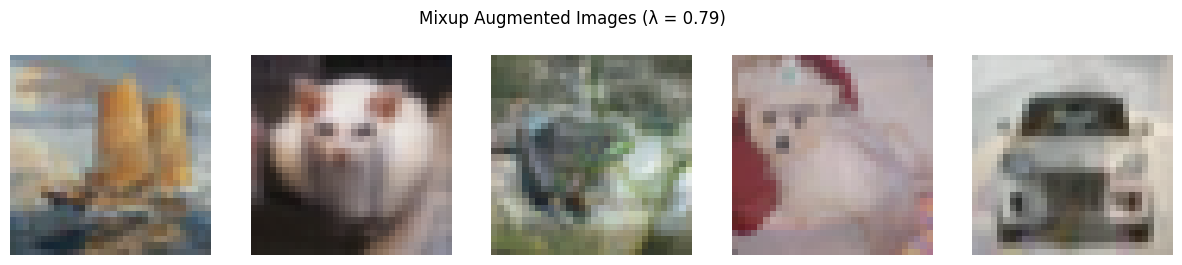


Training with Mixup (α=0.2)
[Mixup] Epoch 1/20 | Train Loss: 1.6266 | Test Loss: 1.2405 | Accuracy: 56.39%
[Mixup] Epoch 2/20 | Train Loss: 1.3258 | Test Loss: 1.1984 | Accuracy: 59.59%
[Mixup] Epoch 3/20 | Train Loss: 1.1579 | Test Loss: 1.0277 | Accuracy: 64.42%
[Mixup] Epoch 4/20 | Train Loss: 1.0947 | Test Loss: 0.9040 | Accuracy: 69.26%
[Mixup] Epoch 5/20 | Train Loss: 1.0499 | Test Loss: 0.8937 | Accuracy: 69.22%
[Mixup] Epoch 6/20 | Train Loss: 0.9468 | Test Loss: 0.9491 | Accuracy: 68.11%
[Mixup] Epoch 7/20 | Train Loss: 0.9342 | Test Loss: 0.8959 | Accuracy: 69.75%
[Mixup] Epoch 8/20 | Train Loss: 0.9205 | Test Loss: 0.9839 | Accuracy: 66.76%
[Mixup] Epoch 9/20 | Train Loss: 0.8791 | Test Loss: 0.9156 | Accuracy: 69.65%
[Mixup] Epoch 10/20 | Train Loss: 0.8000 | Test Loss: 1.0645 | Accuracy: 65.26%
[Mixup] Epoch 11/20 | Train Loss: 0.8240 | Test Loss: 0.8451 | Accuracy: 71.22%
[Mixup] Epoch 12/20 | Train Loss: 0.7803 | Test Loss: 0.9339 | Accuracy: 69.05%
[Mixup] Epoch 13/20 

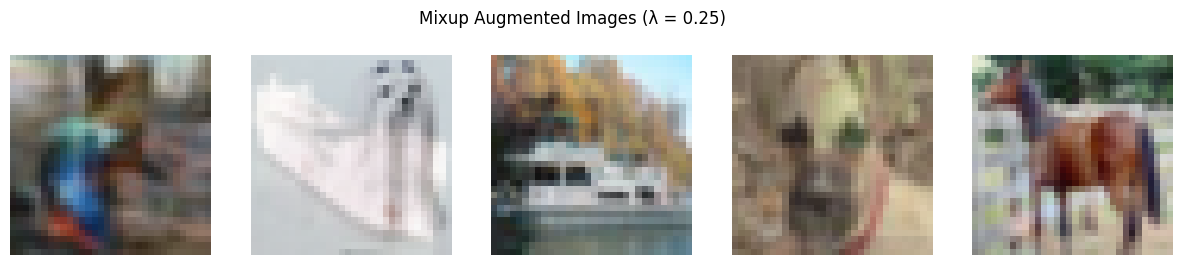


Training with Mixup (α=0.5)
[Mixup] Epoch 1/20 | Train Loss: 1.7382 | Test Loss: 1.2891 | Accuracy: 55.14%
[Mixup] Epoch 2/20 | Train Loss: 1.4444 | Test Loss: 1.1606 | Accuracy: 58.74%
[Mixup] Epoch 3/20 | Train Loss: 1.4001 | Test Loss: 1.0512 | Accuracy: 64.02%
[Mixup] Epoch 4/20 | Train Loss: 1.3514 | Test Loss: 0.9678 | Accuracy: 67.69%
[Mixup] Epoch 5/20 | Train Loss: 1.2565 | Test Loss: 1.1134 | Accuracy: 62.67%
[Mixup] Epoch 6/20 | Train Loss: 1.1851 | Test Loss: 0.9125 | Accuracy: 70.23%
[Mixup] Epoch 7/20 | Train Loss: 1.1406 | Test Loss: 0.9028 | Accuracy: 69.78%
[Mixup] Epoch 8/20 | Train Loss: 1.1006 | Test Loss: 0.9022 | Accuracy: 70.02%
[Mixup] Epoch 9/20 | Train Loss: 1.0943 | Test Loss: 0.9324 | Accuracy: 70.02%
[Mixup] Epoch 10/20 | Train Loss: 1.1049 | Test Loss: 0.8378 | Accuracy: 72.14%
[Mixup] Epoch 11/20 | Train Loss: 1.1312 | Test Loss: 0.8963 | Accuracy: 71.31%
[Mixup] Epoch 12/20 | Train Loss: 1.0323 | Test Loss: 0.8793 | Accuracy: 71.55%
[Mixup] Epoch 13/20 

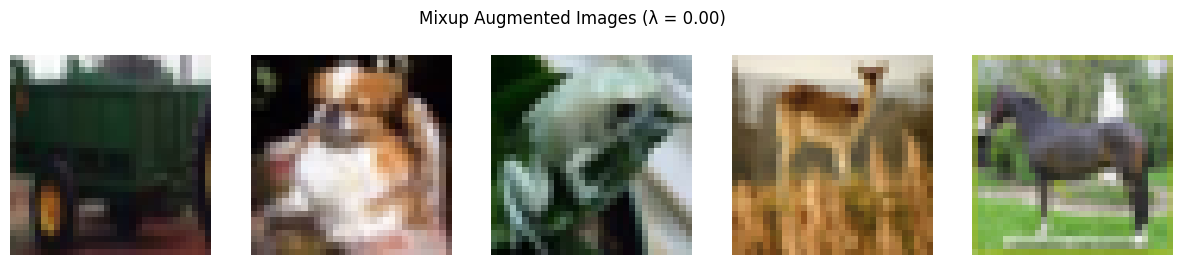


Training with Mixup (α=1.0)
[Mixup] Epoch 1/20 | Train Loss: 1.8395 | Test Loss: 1.4049 | Accuracy: 49.32%
[Mixup] Epoch 2/20 | Train Loss: 1.6165 | Test Loss: 1.1617 | Accuracy: 60.74%
[Mixup] Epoch 3/20 | Train Loss: 1.5306 | Test Loss: 1.1250 | Accuracy: 62.96%
[Mixup] Epoch 4/20 | Train Loss: 1.4802 | Test Loss: 1.1019 | Accuracy: 63.60%
[Mixup] Epoch 5/20 | Train Loss: 1.4330 | Test Loss: 0.9590 | Accuracy: 68.19%
[Mixup] Epoch 6/20 | Train Loss: 1.4086 | Test Loss: 0.9897 | Accuracy: 68.19%
[Mixup] Epoch 7/20 | Train Loss: 1.4143 | Test Loss: 0.9233 | Accuracy: 70.04%
[Mixup] Epoch 8/20 | Train Loss: 1.3765 | Test Loss: 1.0014 | Accuracy: 66.87%
[Mixup] Epoch 9/20 | Train Loss: 1.3584 | Test Loss: 0.9268 | Accuracy: 69.98%
[Mixup] Epoch 10/20 | Train Loss: 1.3038 | Test Loss: 0.9095 | Accuracy: 70.15%
[Mixup] Epoch 11/20 | Train Loss: 1.3196 | Test Loss: 0.8875 | Accuracy: 71.56%
[Mixup] Epoch 12/20 | Train Loss: 1.2760 | Test Loss: 0.8714 | Accuracy: 73.14%
[Mixup] Epoch 13/20 

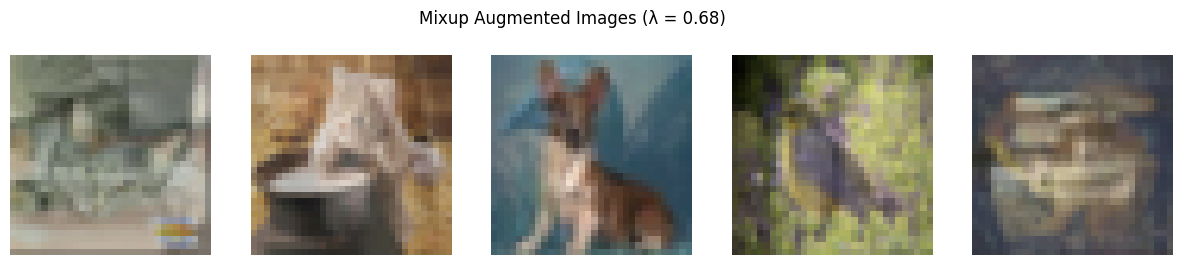


Training with Mixup (α=2.0)
[Mixup] Epoch 1/20 | Train Loss: 1.9411 | Test Loss: 1.5104 | Accuracy: 46.22%
[Mixup] Epoch 2/20 | Train Loss: 1.7388 | Test Loss: 1.2529 | Accuracy: 58.05%
[Mixup] Epoch 3/20 | Train Loss: 1.6837 | Test Loss: 1.1232 | Accuracy: 62.10%
[Mixup] Epoch 4/20 | Train Loss: 1.6240 | Test Loss: 1.1136 | Accuracy: 63.92%
[Mixup] Epoch 5/20 | Train Loss: 1.5843 | Test Loss: 1.0988 | Accuracy: 64.26%
[Mixup] Epoch 6/20 | Train Loss: 1.5616 | Test Loss: 1.1864 | Accuracy: 59.58%
[Mixup] Epoch 7/20 | Train Loss: 1.5165 | Test Loss: 0.9479 | Accuracy: 68.63%
[Mixup] Epoch 8/20 | Train Loss: 1.5012 | Test Loss: 1.0048 | Accuracy: 67.21%
[Mixup] Epoch 9/20 | Train Loss: 1.4909 | Test Loss: 1.0004 | Accuracy: 66.87%
[Mixup] Epoch 10/20 | Train Loss: 1.4760 | Test Loss: 0.9170 | Accuracy: 71.23%
[Mixup] Epoch 11/20 | Train Loss: 1.4547 | Test Loss: 0.9856 | Accuracy: 67.47%
[Mixup] Epoch 12/20 | Train Loss: 1.4364 | Test Loss: 1.0294 | Accuracy: 66.26%
[Mixup] Epoch 13/20 

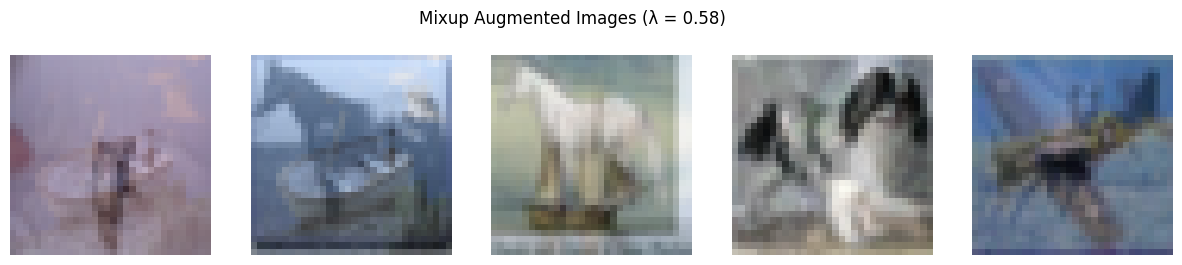

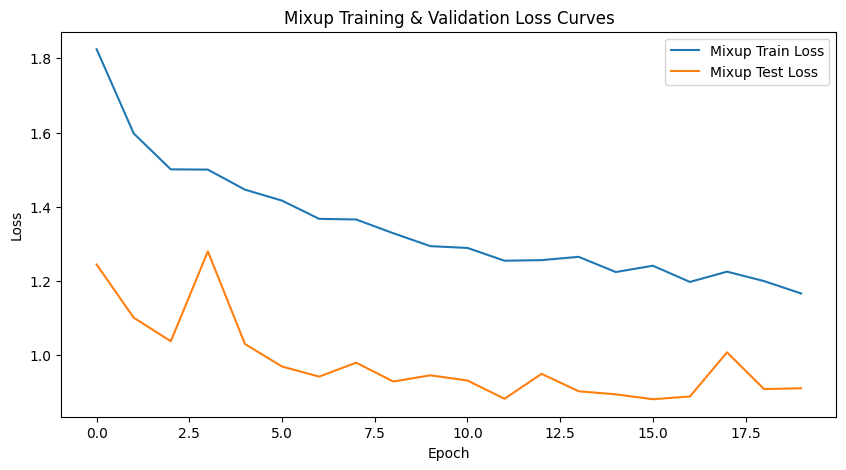

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_cnn_model():
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 10)
    )
    return model.to(device)


def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def train_mixup(model, train_loader, test_loader, optimizer, criterion, num_epochs, alpha=1.0):
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)


            mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha)
            outputs = model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)


        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracy = 100 * correct / len(test_loader.dataset)
        accuracies.append(accuracy)

        print(f"[Mixup] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, accuracies


def visualize_mixup(train_loader, alpha=1.0, num_images=5):
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)
    mixed_images, _, _, lam = mixup_data(images, labels, alpha)

    def denorm(img):
        img = img.cpu().numpy().transpose(1,2,0)
        img = (img * 0.5) + 0.5
        return np.clip(img, 0, 1)

    fig, axs = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        axs[i].imshow(denorm(mixed_images[i]))
        axs[i].axis('off')
    plt.suptitle(f'Mixup Augmented Images (λ = {lam:.2f})')
    plt.show()


def main():
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001


    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])


    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainset_subset = torch.utils.data.Subset(trainset_full, np.random.choice(len(trainset_full), 20000, replace=False))

    train_loader = torch.utils.data.DataLoader(trainset_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


    criterion = nn.CrossEntropyLoss()


    print("\nTraining with Mixup Augmentation")
    model_mixup = get_cnn_model()
    optimizer_mixup = optim.Adam(model_mixup.parameters(), lr=learning_rate)
    train_losses_mixup, test_losses_mixup, accuracies_mixup = train_mixup(model_mixup, train_loader, test_loader, optimizer_mixup, criterion, num_epochs, alpha=1.0)


    visualize_mixup(train_loader, alpha=1.0, num_images=5)

    alpha_values = [0.2, 0.5, 1.0, 2.0]
    for alpha in alpha_values:
        print(f"\nTraining with Mixup (α={alpha})")
        model_mixup = get_cnn_model()
        optimizer_mixup = optim.Adam(model_mixup.parameters(), lr=learning_rate)
        train_mixup(model_mixup, train_loader, test_loader, optimizer_mixup, criterion, num_epochs, alpha=alpha)
        visualize_mixup(train_loader, alpha=alpha, num_images=5)

    plt.figure(figsize=(10,5))
    plt.plot(train_losses_mixup, label='Mixup Train Loss')
    plt.plot(test_losses_mixup, label='Mixup Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Mixup Training & Validation Loss Curves")
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


**Manifold Mixup: Mixup in the feature space**

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]



Training with Manifold Mixup (k=1, α=0.2)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.5845 | Test Loss: 1.3908 | Accuracy: 51.42%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.3395 | Test Loss: 1.0858 | Accuracy: 61.85%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.2038 | Test Loss: 1.0057 | Accuracy: 65.19%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.0819 | Test Loss: 0.9308 | Accuracy: 68.09%
[Manifold Mixup] Epoch 5/20 | Train Loss: 0.9826 | Test Loss: 0.9737 | Accuracy: 66.73%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.0142 | Test Loss: 0.9112 | Accuracy: 69.52%
[Manifold Mixup] Epoch 7/20 | Train Loss: 0.8784 | Test Loss: 0.9233 | Accuracy: 68.74%
[Manifold Mixup] Epoch 8/20 | Train Loss: 0.8773 | Test Loss: 0.9239 | Accuracy: 68.97%
[Manifold Mixup] Epoch 9/20 | Train Loss: 0.8785 | Test Loss: 0.8908 | Accuracy: 69.93%
[Manifold Mixup] Epoch 10/20 | Train Loss: 0.8847 | Test Loss: 0.9559 | Accuracy: 68.69%
[Manifold Mixup] Epoch 11/20 | Train Loss: 0.7747 | Test Loss: 0.8714 | Accu

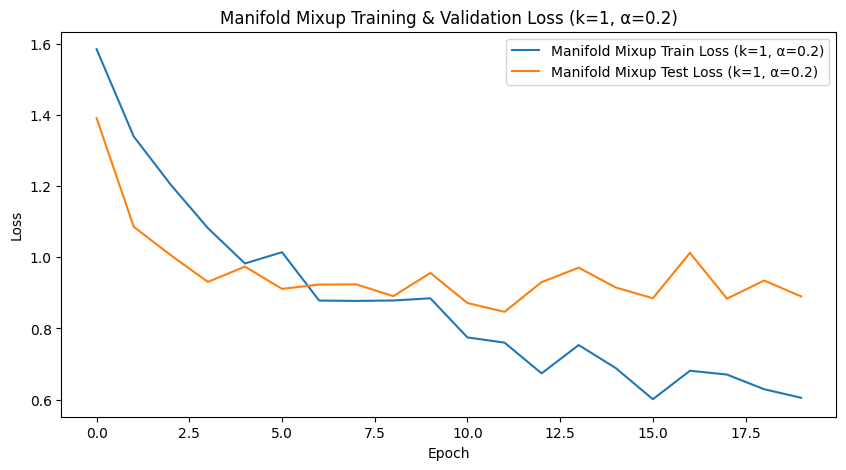


Training with Manifold Mixup (k=1, α=0.5)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.7206 | Test Loss: 1.2808 | Accuracy: 54.69%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.4842 | Test Loss: 1.0691 | Accuracy: 63.72%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.3526 | Test Loss: 1.0541 | Accuracy: 62.92%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.3473 | Test Loss: 1.0146 | Accuracy: 65.71%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.3007 | Test Loss: 0.9980 | Accuracy: 66.81%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.2266 | Test Loss: 0.9464 | Accuracy: 68.13%
[Manifold Mixup] Epoch 7/20 | Train Loss: 1.1955 | Test Loss: 0.9404 | Accuracy: 68.89%
[Manifold Mixup] Epoch 8/20 | Train Loss: 1.1667 | Test Loss: 0.9584 | Accuracy: 68.05%
[Manifold Mixup] Epoch 9/20 | Train Loss: 1.1301 | Test Loss: 0.8855 | Accuracy: 71.21%
[Manifold Mixup] Epoch 10/20 | Train Loss: 1.1356 | Test Loss: 0.9108 | Accuracy: 69.41%
[Manifold Mixup] Epoch 11/20 | Train Loss: 1.0714 | Test Loss: 0.8557 | Accu

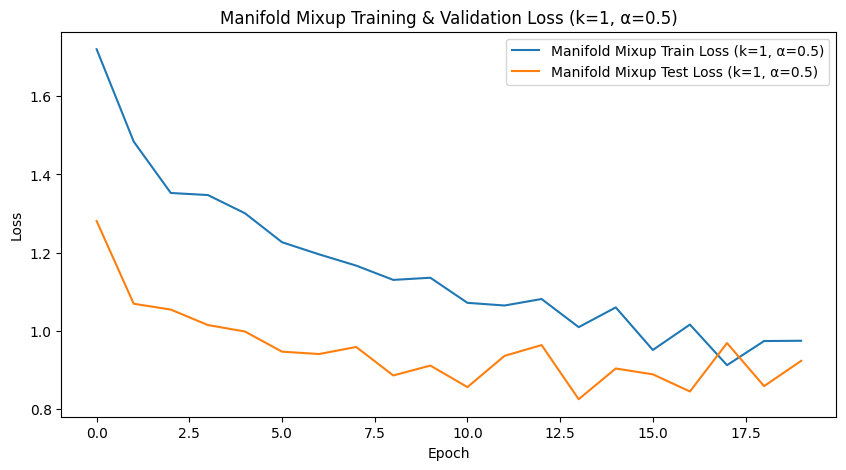


Training with Manifold Mixup (k=1, α=1.0)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.8642 | Test Loss: 1.3661 | Accuracy: 52.65%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.6109 | Test Loss: 1.1149 | Accuracy: 61.52%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.5230 | Test Loss: 1.2139 | Accuracy: 57.10%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.4997 | Test Loss: 1.0294 | Accuracy: 65.93%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.4235 | Test Loss: 1.0337 | Accuracy: 65.95%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.3782 | Test Loss: 0.9759 | Accuracy: 68.37%
[Manifold Mixup] Epoch 7/20 | Train Loss: 1.3717 | Test Loss: 0.9476 | Accuracy: 68.64%
[Manifold Mixup] Epoch 8/20 | Train Loss: 1.3378 | Test Loss: 0.9211 | Accuracy: 70.03%
[Manifold Mixup] Epoch 9/20 | Train Loss: 1.3608 | Test Loss: 0.9198 | Accuracy: 69.74%
[Manifold Mixup] Epoch 10/20 | Train Loss: 1.3101 | Test Loss: 0.9319 | Accuracy: 68.98%
[Manifold Mixup] Epoch 11/20 | Train Loss: 1.2846 | Test Loss: 0.9679 | Accu

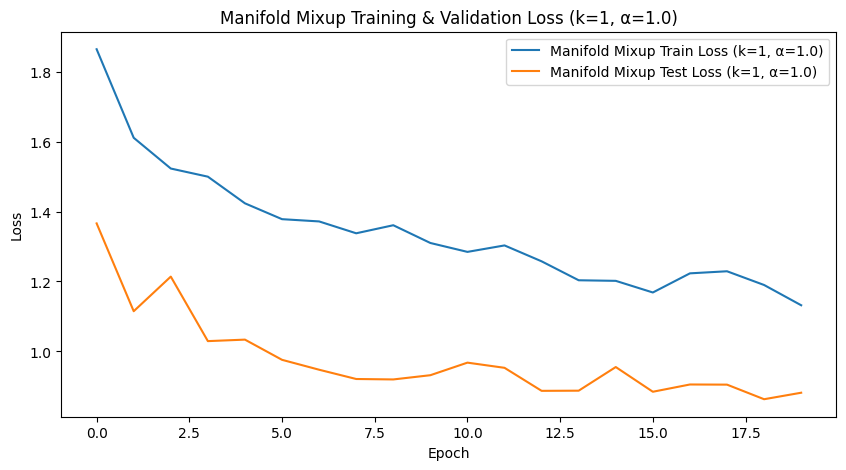


Training with Manifold Mixup (k=2, α=0.2)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.6046 | Test Loss: 1.1775 | Accuracy: 58.28%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.3253 | Test Loss: 1.0539 | Accuracy: 63.18%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.1440 | Test Loss: 0.9634 | Accuracy: 66.56%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.0859 | Test Loss: 1.1133 | Accuracy: 62.21%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.0689 | Test Loss: 0.9784 | Accuracy: 66.57%
[Manifold Mixup] Epoch 6/20 | Train Loss: 0.9990 | Test Loss: 0.8830 | Accuracy: 70.07%
[Manifold Mixup] Epoch 7/20 | Train Loss: 0.8993 | Test Loss: 0.8836 | Accuracy: 70.37%
[Manifold Mixup] Epoch 8/20 | Train Loss: 0.9099 | Test Loss: 0.8704 | Accuracy: 71.26%
[Manifold Mixup] Epoch 9/20 | Train Loss: 0.8460 | Test Loss: 0.9453 | Accuracy: 67.93%
[Manifold Mixup] Epoch 10/20 | Train Loss: 0.7925 | Test Loss: 0.8730 | Accuracy: 70.43%
[Manifold Mixup] Epoch 11/20 | Train Loss: 0.8695 | Test Loss: 0.9311 | Accu

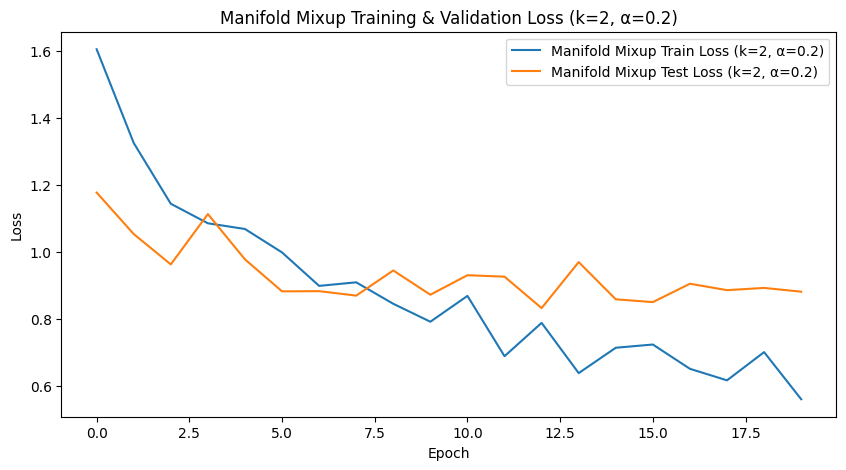


Training with Manifold Mixup (k=2, α=0.5)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.7412 | Test Loss: 1.3301 | Accuracy: 52.75%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.5150 | Test Loss: 1.1172 | Accuracy: 61.43%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.3779 | Test Loss: 1.0582 | Accuracy: 64.27%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.3347 | Test Loss: 0.9552 | Accuracy: 68.12%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.2766 | Test Loss: 0.9260 | Accuracy: 69.39%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.2164 | Test Loss: 1.0643 | Accuracy: 63.86%
[Manifold Mixup] Epoch 7/20 | Train Loss: 1.2383 | Test Loss: 1.0141 | Accuracy: 65.44%
[Manifold Mixup] Epoch 8/20 | Train Loss: 1.1560 | Test Loss: 0.8889 | Accuracy: 71.07%
[Manifold Mixup] Epoch 9/20 | Train Loss: 1.1493 | Test Loss: 0.8975 | Accuracy: 69.70%
[Manifold Mixup] Epoch 10/20 | Train Loss: 1.1032 | Test Loss: 0.8949 | Accuracy: 69.27%
[Manifold Mixup] Epoch 11/20 | Train Loss: 1.0276 | Test Loss: 0.8855 | Accu

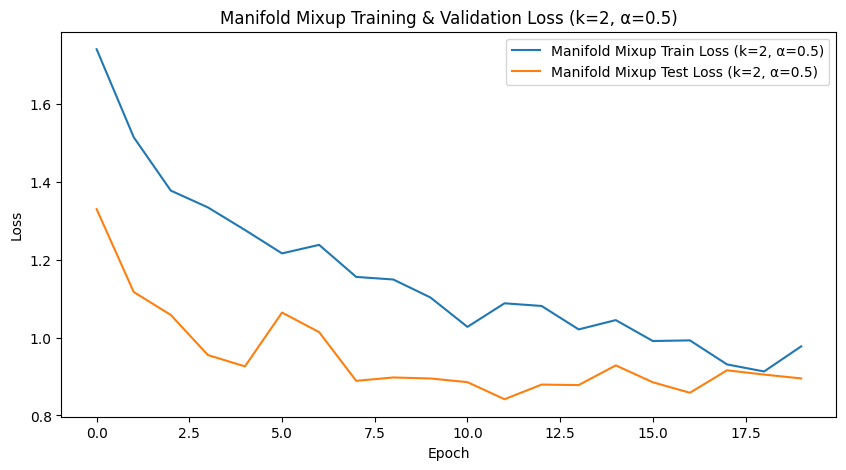


Training with Manifold Mixup (k=2, α=1.0)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.8384 | Test Loss: 1.3169 | Accuracy: 55.19%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.6273 | Test Loss: 1.1152 | Accuracy: 61.35%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.5543 | Test Loss: 1.1568 | Accuracy: 61.06%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.4741 | Test Loss: 1.2076 | Accuracy: 59.09%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.4261 | Test Loss: 1.0476 | Accuracy: 65.30%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.3824 | Test Loss: 0.9137 | Accuracy: 70.54%
[Manifold Mixup] Epoch 7/20 | Train Loss: 1.3866 | Test Loss: 0.9492 | Accuracy: 68.45%
[Manifold Mixup] Epoch 8/20 | Train Loss: 1.3232 | Test Loss: 1.0071 | Accuracy: 66.09%
[Manifold Mixup] Epoch 9/20 | Train Loss: 1.3456 | Test Loss: 0.9372 | Accuracy: 69.56%
[Manifold Mixup] Epoch 10/20 | Train Loss: 1.2934 | Test Loss: 0.9227 | Accuracy: 70.26%
[Manifold Mixup] Epoch 11/20 | Train Loss: 1.2548 | Test Loss: 0.8735 | Accu

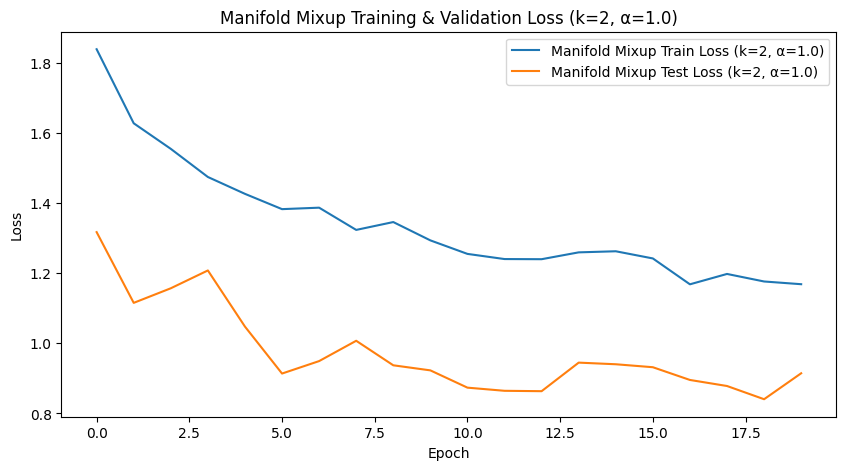


Training with Manifold Mixup (k=3, α=0.2)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.6257 | Test Loss: 1.2537 | Accuracy: 55.58%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.2789 | Test Loss: 1.2248 | Accuracy: 57.60%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.2066 | Test Loss: 0.9470 | Accuracy: 68.29%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.0627 | Test Loss: 0.9283 | Accuracy: 67.37%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.0375 | Test Loss: 0.9436 | Accuracy: 67.94%
[Manifold Mixup] Epoch 6/20 | Train Loss: 0.8707 | Test Loss: 0.8843 | Accuracy: 69.55%
[Manifold Mixup] Epoch 7/20 | Train Loss: 0.8957 | Test Loss: 0.8534 | Accuracy: 70.98%
[Manifold Mixup] Epoch 8/20 | Train Loss: 0.8831 | Test Loss: 0.8746 | Accuracy: 70.21%
[Manifold Mixup] Epoch 9/20 | Train Loss: 0.7964 | Test Loss: 0.9004 | Accuracy: 69.64%
[Manifold Mixup] Epoch 10/20 | Train Loss: 0.8181 | Test Loss: 0.9757 | Accuracy: 67.68%
[Manifold Mixup] Epoch 11/20 | Train Loss: 0.7682 | Test Loss: 0.9189 | Accu

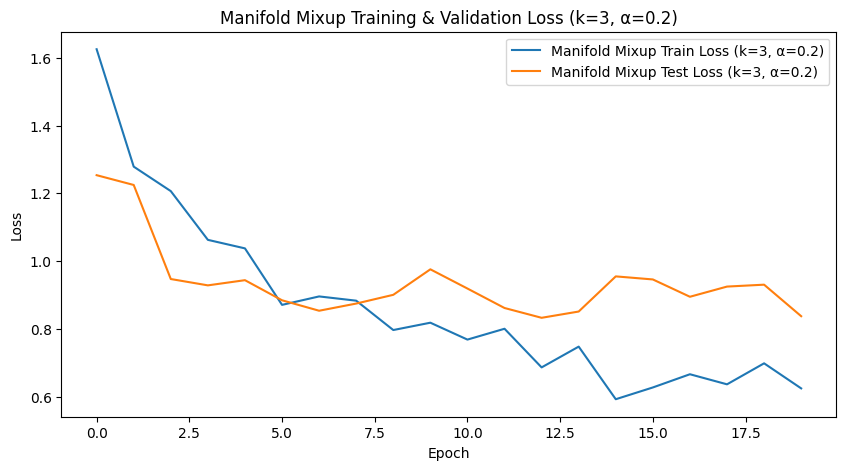


Training with Manifold Mixup (k=3, α=0.5)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.7664 | Test Loss: 1.2699 | Accuracy: 56.21%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.4802 | Test Loss: 1.1201 | Accuracy: 60.82%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.3773 | Test Loss: 1.0122 | Accuracy: 65.34%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.3121 | Test Loss: 1.0317 | Accuracy: 64.47%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.2567 | Test Loss: 0.9678 | Accuracy: 67.22%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.1949 | Test Loss: 0.9278 | Accuracy: 68.65%
[Manifold Mixup] Epoch 7/20 | Train Loss: 1.2005 | Test Loss: 0.9834 | Accuracy: 66.82%
[Manifold Mixup] Epoch 8/20 | Train Loss: 1.1282 | Test Loss: 0.8735 | Accuracy: 70.45%
[Manifold Mixup] Epoch 9/20 | Train Loss: 1.1314 | Test Loss: 0.8864 | Accuracy: 70.16%
[Manifold Mixup] Epoch 10/20 | Train Loss: 1.0970 | Test Loss: 0.8326 | Accuracy: 72.23%
[Manifold Mixup] Epoch 11/20 | Train Loss: 1.0869 | Test Loss: 0.8473 | Accu

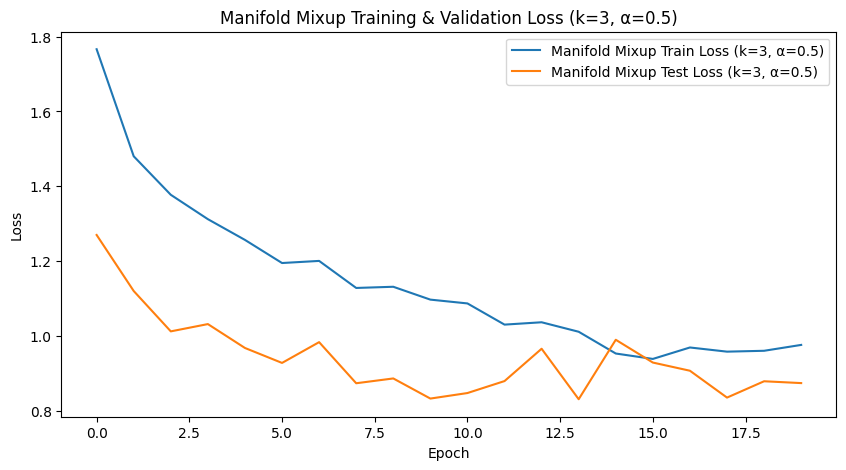


Training with Manifold Mixup (k=3, α=1.0)
[Manifold Mixup] Epoch 1/20 | Train Loss: 1.7912 | Test Loss: 1.3429 | Accuracy: 52.79%
[Manifold Mixup] Epoch 2/20 | Train Loss: 1.6139 | Test Loss: 1.2544 | Accuracy: 57.23%
[Manifold Mixup] Epoch 3/20 | Train Loss: 1.4836 | Test Loss: 1.0602 | Accuracy: 64.56%
[Manifold Mixup] Epoch 4/20 | Train Loss: 1.4435 | Test Loss: 1.0094 | Accuracy: 65.37%
[Manifold Mixup] Epoch 5/20 | Train Loss: 1.4280 | Test Loss: 0.9883 | Accuracy: 65.56%
[Manifold Mixup] Epoch 6/20 | Train Loss: 1.3688 | Test Loss: 0.9236 | Accuracy: 69.70%
[Manifold Mixup] Epoch 7/20 | Train Loss: 1.3665 | Test Loss: 0.9898 | Accuracy: 66.59%
[Manifold Mixup] Epoch 8/20 | Train Loss: 1.2740 | Test Loss: 0.9340 | Accuracy: 68.67%
[Manifold Mixup] Epoch 9/20 | Train Loss: 1.3132 | Test Loss: 0.8865 | Accuracy: 70.22%
[Manifold Mixup] Epoch 10/20 | Train Loss: 1.2374 | Test Loss: 0.8493 | Accuracy: 71.27%
[Manifold Mixup] Epoch 11/20 | Train Loss: 1.2190 | Test Loss: 0.9915 | Accu

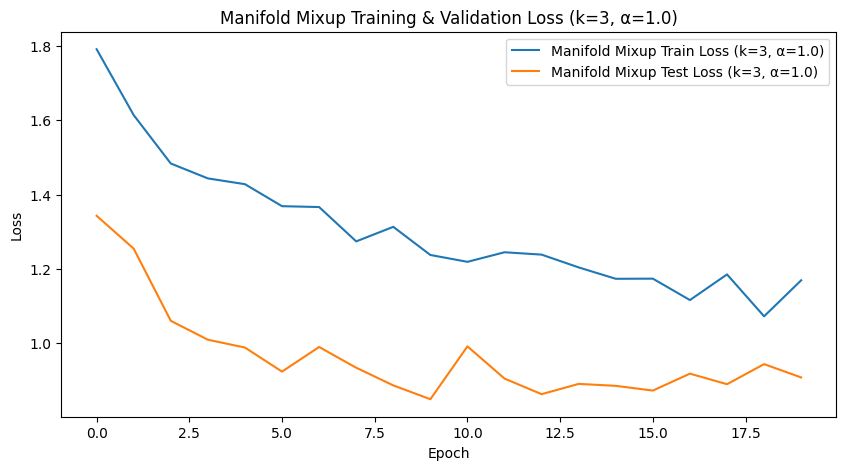

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# same as mixup
def get_cnn_model():
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 10)
    )
    return model.to(device)


def manifold_mixup(features, labels, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = features.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_features = lam * features + (1 - lam) * features[index, :]
    y_a, y_b = labels, labels[index]
    return mixed_features, y_a, y_b, lam


def train_manifold_mixup(model, train_loader, test_loader, optimizer, criterion, num_epochs, k_layer=2, alpha=1.0):
    train_losses, test_losses, accuracies = [], [], []

    layers = list(model.children())

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            x = images
            for i in range(k_layer):
                x = layers[i](x)

            mixed_x, targets_a, targets_b, lam = manifold_mixup(x, labels, alpha)

            for i in range(k_layer, len(layers)):
                mixed_x = layers[i](mixed_x)

            outputs = mixed_x
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)


        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracy = 100 * correct / len(test_loader.dataset)
        accuracies.append(accuracy)

        print(f"[Manifold Mixup] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, accuracies


def main():
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainset_subset = torch.utils.data.Subset(trainset_full, np.random.choice(len(trainset_full), 20000, replace=False))

    train_loader = torch.utils.data.DataLoader(trainset_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


    criterion = nn.CrossEntropyLoss()


    k_values = [1, 2, 3]
    alpha_values = [0.2, 0.5, 1.0]

    for k in k_values:
        for alpha in alpha_values:
            print(f"\nTraining with Manifold Mixup (k={k}, α={alpha})")
            model = get_cnn_model()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            train_losses, test_losses, accuracies = train_manifold_mixup(model, train_loader, test_loader, optimizer, criterion, num_epochs, k_layer=k, alpha=alpha)

            plt.figure(figsize=(10,5))
            plt.plot(train_losses, label=f'Manifold Mixup Train Loss (k={k}, α={alpha})')
            plt.plot(test_losses, label=f'Manifold Mixup Test Loss (k={k}, α={alpha})')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Manifold Mixup Training & Validation Loss (k={k}, α={alpha})")
            plt.legend()
            plt.show()

if __name__ == '__main__':
    main()
